## Introduction

The goal of this notebook is to train models that only have to predict if a line belongs to a certain character or not, binarizing the classes into "CHARACTER" and "NOT CHARACTER".  This could be used as a measure of uniqueness of the character, as well as be plain interesting.  

The first model presented, however, makes predictions for all of the classes.  It trains one of these models for each character, and compares their prediction confidences to make a prediction overall.  I was interested to see if allowing each class to have its own model would increase accuracy.

The rest of the models individual to each character, as described firstly.

## Imports, Classes, and Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

import concurrent.futures
import time

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import clone

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])

## Dataset Preprocessing

In [2]:
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

np.random.seed(RANDOM_SEED)
mcu_subset = mcu_subset.reindex(np.random.permutation(mcu_subset.index))

mcu_subset.head()

,Unnamed: 0,character,line,movie,year,words,Adam McKay,Anna Boden,Art Marcum,Ashley Edward Miller,...,Joss Whedon,Justin Theroux,Mark Fergus,Matt Holloway,Paul Rudd,Ryan Coogler,Ryan Fleck,Shane Black,Stephen McFeely,Zack Stentz
1263,2218,THOR,"Stay here. Once I have Mjolnir, I will return what they stole from you. Deal?",Thor,2011,15,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3951,7527,THOR,They'll try to leave the city.,Avengers: Age of Ultron,2015,6,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4198,8890,TONY STARK,"Oh, yeah. It'd be great if we had a Hulk right about now. Any shot?",Captain America: Civil War,2016,15,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6078,14843,BRUCE BANNER,It was worse for me. Because I lost twice. First Hulk lost. Then Banner lost. Then we all lost.,Avengers: Endgame,2019,23,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96,141,TONY STARK,"Okay, here’s what I need... S-Category missiles. Lot 7043. The S-30 explosive tritonal. And a dozen of the S-76. Mortars: M-Category #1, 4, 8, 20, and 60. M- 229’s, I need eleven of these. Mines: the pre-90s AP 5s and AP 16s.",Iron Man,2008,49,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False


In [3]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1788
STEVE ROGERS,977
THOR,863
PETER PARKER,551
NATASHA ROMANOFF,498
PEPPER POTTS,442
BRUCE BANNER,379
NICK FURY,366
LOKI,327
JAMES RHODES,318


In [4]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X[0:10], y[0:10]

(array(['Stay here. Once I have Mjolnir, I will return what they stole from you. Deal?',
        "They'll try to leave the city.",
        "Oh, yeah. It'd be great if we had a Hulk right about now. Any shot?",
        'It was worse for me.  Because I lost twice.  First Hulk lost.  Then Banner lost.  Then we all lost.',
        'Okay, here’s what I need... S-Category missiles.  Lot 7043.  The S-30 explosive tritonal.  And a dozen of the S-76.  Mortars: M-Category #1, 4, 8, 20, and 60.  M- 229’s, I need eleven of these.  Mines: the pre-90s AP 5s and AP 16s. ',
        'A little.',
        "You really think I'd need one? My wife kicked me out.",
        'Is this is a test?', 'What about Ultron himself?',
        'Who put me there? Who put me there?!'], dtype='<U1388'),
 array(['THOR', 'THOR', 'TONY STARK', 'BRUCE BANNER', 'TONY STARK',
        'STEVE ROGERS', 'NICK FURY', 'STEVE ROGERS', 'STEVE ROGERS',
        'LOKI'], dtype='<U16'))

## All Classes Model (Model 14)

In [5]:
cross_validator = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [6]:
class OVR_Model(BaseEstimator):
    '''
    Trains a different model for each label that predits
    'LABEL' and 'NOT LABEL'.  Prediction creates probabilities
    for each 'LABEL' and returns the label with the highest probability
    '''
    def __init__(self, base_model):
        self.base_model = base_model
        self.models = []
        self.classes_ = []
        
    def fit(self, X, y, verbose=False):
        
        self.classes_ = np.unique(y)
        
        def train_model(X,y,label):
            if verbose:
                import warnings
                warnings.simplefilter('always')
                warnings.warn("Training a model model '" + label + "'")
                start = time.time()
            
            binary_y = (y == np.full(y.shape, label))
            new_model = clone(self.base_model)
            new_model.fit(X, binary_y)
            
            return new_model
            
            if verbose:
                end = time.time()
                warnings.warn("Finished training model '" + label + "'.  Elapsed time: " + str(end-start) + "s")
                
        with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
            futures = []
            for label in self.classes_:
                futures.append(executor.submit(train_model, X, y, label))
                
            for i in range(0,len(futures)):
                try:
                    new_model = futures[i].result()
                    self.models.append(new_model)
                except Exception as exc:
                    print('Training %r generated an exception: %s' % (self.classes_[i], exc))            
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]
        
    def predict_proba(self, X, verbose=False):
        probabilities = np.empty(shape=(len(X), 0))
                                 
        def predict_proba_model(model,x):
            if verbose:
                import warnings
                warnings.simplefilter('always')
                warnings.warn("Predicting using model '" + label + "'")
                start = time.time()
                                 
            label_probs = model.predict_proba(x)[:, list(model.classes_).index(True)]
            
            if verbose:
                end = time.time()
                warnings.warn("Finished predicting using model '" + label + "'.  Elapsed time: " + str(end-start) + "s")
                                 
            return label_probs
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
            futures = []
            for model in self.models:
                futures.append(executor.submit(predict_proba_model, model, X))
                
            for i in range(0,len(futures)):
                try:
                    label_probs = futures[i].result()
                except Exception as exc:
                    print('Exception Generated: %s' % (exc))
                else:
                    probabilities = np.concatenate((probabilities, np.expand_dims(label_probs, axis=1)), axis=1)
         
        return probabilities
        

In [7]:
base_model = load("./front_end/production_model.joblib")

model14 = OVR_Model(base_model)

### Nested CV Balanced Accuracy

In [8]:
models = {"model 14": model14}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 15.6min remaining: 36.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 15.9min remaining: 15.9min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 16.1min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 16.1min finished


,model 14
fold,
0,0.076621
1,0.326696
2,0.083218
3,0.295073
4,0.316480
5,0.308278
6,0.103476
7,0.074433
8,0.085160


### Confusion Matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 35.7min remaining: 83.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 35.7min remaining: 35.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 35.8min remaining: 15.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 35.8min finished


Balanced Accuracy: 0.2971799112326868
Balanced Accuracy: 0.2971799112326868


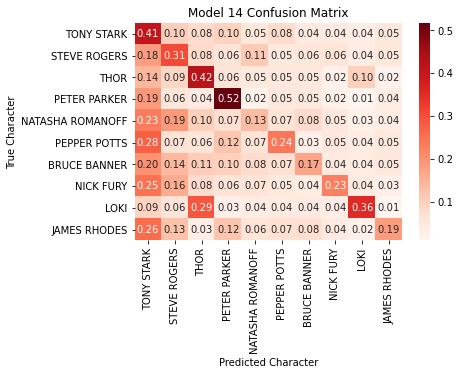

In [9]:
yhat = cross_val_predict(model14, X, y, cv=cross_validator, n_jobs=-1, verbose=6)

main_characters = mcu_subset['character'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Model 14 Confusion Matrix")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))

## Individual Character Models

In [10]:
def binarize_labels(y, label):
        binarized_y = np.copy(y)
        binarized_y = binarized_y.astype('object')
        binarized_y[np.argwhere(binarized_y != label)] = 'NOT ' + label
        return binarized_y

class Individual_Character_Model(BaseEstimator):
    '''
    Just a wrapper class to hold a label for a given character
    and to plot a confusion matrix
    '''
    def __init__(self, label, base_model):
        self.label = label
        self.base_model = base_model
        self.model = None
        self.classes_ = [label, 'NOT ' + label]
        self.confusion_matrix = None
        self.recalls = None
        
    def fit(self,X,y):
        self.model = clone(self.base_model)
        self.model.fit(X, y)
        
    def predict(self,X):
        return self.model.predict(X)
    
    def plot_confusion_matrix(self):
        if self.confusion_matrix is None:
            binarized_y = binarize_labels(y, self.label)
            yhat = cross_val_predict(self, X, binarized_y, cv=cross_validator, n_jobs=-1, verbose=6)

            conf_matrix = pd.DataFrame(metrics.confusion_matrix(binarized_y, yhat, labels=self.classes_))
            normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
            normalized_conf_matrix.columns = pd.Series(self.classes_, name="Predicted Character")
            normalized_conf_matrix.index = pd.Series(self.classes_, name="True Character")
            
            self.confusion_matrix = normalized_conf_matrix
            self.recalls = pd.DataFrame(np.diagonal(normalized_conf_matrix.to_numpy()))

        plt.title("Proportion of a True Character's Examples")
        sns.heatmap(self.confusion_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

        print("Balanced Accuracy:", np.mean(np.diagonal(self.confusion_matrix)))
        

In [11]:
base_model = load("./front_end/production_model.joblib")

tony_model = Individual_Character_Model('TONY STARK', base_model)
steve_model = Individual_Character_Model('STEVE ROGERS', base_model)
thor_model = Individual_Character_Model('THOR', base_model)
peter_model = Individual_Character_Model('PETER PARKER', base_model)
natasha_model = Individual_Character_Model('NATASHA ROMANOFF', base_model)
pepper_model = Individual_Character_Model('PEPPER POTTS', base_model)
bruce_model = Individual_Character_Model('BRUCE BANNER', base_model)
fury_model = Individual_Character_Model('NICK FURY', base_model)
loki_model = Individual_Character_Model('LOKI', base_model)
james_model = Individual_Character_Model('JAMES RHODES', base_model)

### Nested CV Balanced Accuracy

In [12]:
models = {"tony_model": tony_model, "steve_model": steve_model, "thor_model": thor_model, "peter_model": peter_model,
         "natasha_model": natasha_model, "pepper_model": pepper_model, "bruce_model": bruce_model, 
          "fury_model": fury_model, "loki_model": loki_model, "james_model": james_model}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    print("Scoring model:", name)
    
    results = cross_val_score(model, X, binarize_labels(y, model.label), cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

Scoring model: tony_model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 20.7min remaining: 48.3min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 20.7min remaining: 20.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 20.7min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.7min finished


Scoring model: steve_model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 20.9min remaining: 48.7min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 20.9min remaining: 20.9min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 20.9min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.9min finished


Scoring model: thor_model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 20.4min remaining: 47.6min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 20.4min remaining: 20.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 20.4min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.4min finished


Scoring model: peter_model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 20.4min remaining: 47.7min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 20.4min remaining: 20.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 20.5min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.5min finished


Scoring model: natasha_model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 20.5min remaining: 47.9min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 20.5min remaining: 20.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 20.6min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.6min finished


Scoring model: pepper_model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 22.3min remaining: 52.0min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 22.3min remaining: 22.3min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 22.3min remaining:  9.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 22.4min finished


Scoring model: bruce_model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 21.4min remaining: 49.9min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 21.4min remaining: 21.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 21.4min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 21.4min finished


Scoring model: fury_model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 20.4min remaining: 47.6min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 20.4min remaining: 20.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 20.4min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.5min finished


Scoring model: loki_model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 20.3min remaining: 47.5min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 20.4min remaining: 20.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 20.4min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.4min finished


Scoring model: james_model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 11.8min remaining: 27.6min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 11.8min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 11.8min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.8min finished


,tony_model,steve_model,thor_model,peter_model,natasha_model,pepper_model,bruce_model,fury_model,loki_model,james_model
fold,,,,,,,,,,
0,0.572226,0.593770,0.603265,0.732047,0.554105,0.603078,0.585902,0.586789,0.681593,0.557258
1,0.591824,0.594030,0.648325,0.669250,0.592579,0.702879,0.604168,0.591667,0.629064,0.539630
2,0.619360,0.620641,0.691703,0.761836,0.536755,0.617736,0.621405,0.599864,0.698956,0.568457
3,0.594321,0.614893,0.690831,0.714841,0.517587,0.577879,0.575191,0.589533,0.603781,0.532083
4,0.595765,0.611599,0.745308,0.703935,0.528419,0.621031,0.573452,0.623889,0.716314,0.559017
5,0.573135,0.609532,0.705114,0.755400,0.473428,0.633219,0.578561,0.594419,0.620550,0.528852
6,0.606459,0.631749,0.667576,0.701556,0.538403,0.617736,0.607324,0.516595,0.731465,0.633103
7,0.592108,0.598360,0.647860,0.699176,0.525923,0.606821,0.578561,0.596862,0.675713,0.614247
8,0.575928,0.617605,0.680212,0.798319,0.566772,0.605611,0.511140,0.606634,0.708444,0.604554


Peter Parker performs the best, which is more evidence that he is the most unique character.  See the MCU Insights notebook for more on this topic.

### Confusion Matricies

#### Tony Stark

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  3.1min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  3.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.1min finished


Balanced Accuracy: 0.5934149004377129


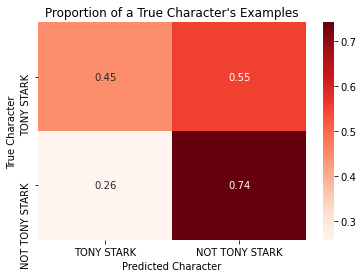

In [13]:
tony_model.plot_confusion_matrix()

#### Steve Rogers

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.9min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.9min remaining:   47.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished


Balanced Accuracy: 0.6105691201317949


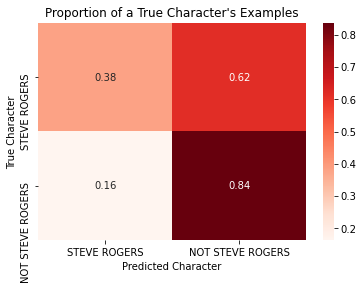

In [14]:
steve_model.plot_confusion_matrix()

#### Thor

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.5min remaining:   37.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


Balanced Accuracy: 0.6783173641117964


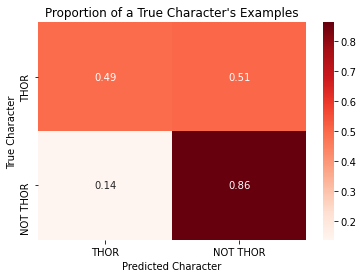

In [15]:
thor_model.plot_confusion_matrix()

#### Peter Parker

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.5min remaining:   38.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


Balanced Accuracy: 0.7284319029333587


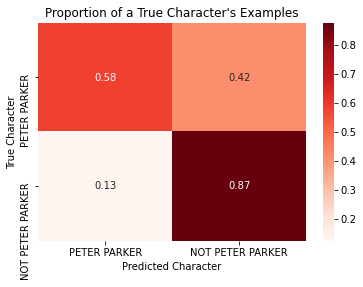

In [16]:
peter_model.plot_confusion_matrix()

#### Natasha Romanoff

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.5min remaining:   37.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


Balanced Accuracy: 0.5387951740417


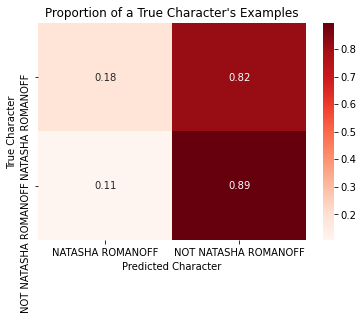

In [17]:
natasha_model.plot_confusion_matrix()

#### Pepper Potts

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.5min remaining:   38.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


Balanced Accuracy: 0.6187215982613457


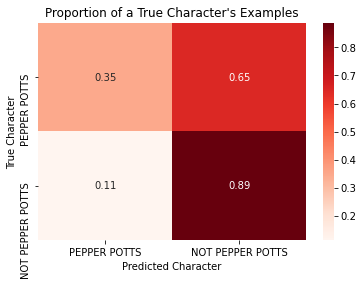

In [18]:
pepper_model.plot_confusion_matrix()

#### Bruce Banner

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.5min remaining:   37.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


Balanced Accuracy: 0.5812735928239077


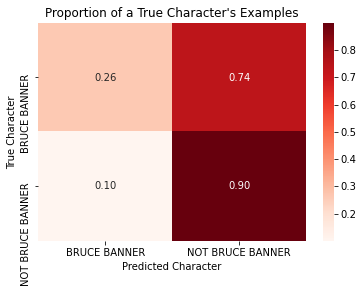

In [19]:
bruce_model.plot_confusion_matrix()

#### Nick Fury

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.5min remaining:   38.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


Balanced Accuracy: 0.5878351030850344


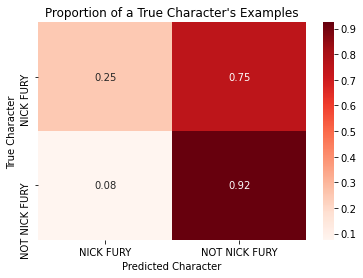

In [20]:
fury_model.plot_confusion_matrix()

#### Loki

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.5min remaining:   37.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


Balanced Accuracy: 0.6728261590075557


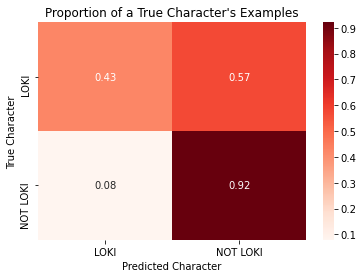

In [21]:
loki_model.plot_confusion_matrix()

#### James Rhodes

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.5min remaining:   37.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


Balanced Accuracy: 0.5759230024513166


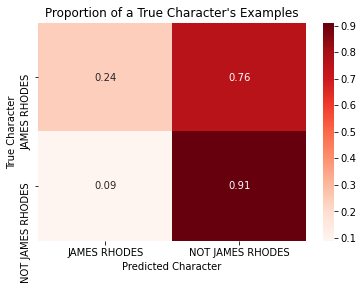

In [22]:
james_model.plot_confusion_matrix()

### Recalls

In [23]:
recalls = pd.DataFrame(columns=["recall"])

for name, model in models.items():
    new_rows = model.recalls
    new_rows.index = model.classes_
    new_rows.columns = ['recall']
    recalls = recalls.append(new_rows)

recalls.sort_values(by="recall", ascending=False, inplace=True)
recalls.loc['mean'] = recalls.mean()

recalls

,recall
NOT NICK FURY,0.924304
NOT LOKI,0.920576
NOT JAMES RHODES,0.909708
NOT BRUCE BANNER,0.898695
NOT NATASHA ROMANOFF,0.894859
NOT PEPPER POTTS,0.886764
NOT PETER PARKER,0.874287
NOT THOR,0.861849
NOT STEVE ROGERS,0.837310
NOT TONY STARK,0.740521


## Conclusion

Model 14 did perform better than the production model, but only by less than a percent.  As cross validation only gives an estimate of our models performance, the models are likely equal in performance.  The  current production model will be used because it is faster / simpler.  The equal performance is likely because no additional information is available in prediction.  In fact, this model might have a disadvantage because the underlying models don't have the ability to share information about the distinctions between classes.

As for the individual character models, they're interesting to look at.  The recalls of the characters match the rankings we see in the production model, which is expected. What is interesting is the rankings of the `NOT CHARACTER` classes.  It provides a little more information about a character's uniqueness compared to the others.  These recalls are higher than the `CHARACTER` recalls because they are trained / predicted with more examples.